## 1. Installing Dependencies and Setup

In [1]:
%pip install tensorflow opencv-python matplotlib

In [7]:
%pip list

Package                      Version
---------------------------- ------------
absl-py                      1.4.0
aiohttp                      3.8.4
aiosignal                    1.3.1
albumentations               1.3.0
alembic                      1.10.2
alpha-vantage                2.3.1
aniso8601                    9.0.1
anyio                        3.6.2
apispec                      6.3.0
appdirs                      1.4.4
asgiref                      3.6.0
asttokens                    2.2.1
astunparse                   1.6.3
async-generator              1.10
async-timeout                4.0.2
asyncio                      3.4.3
attrs                        22.2.0
backcall                     0.2.0
beautifulsoup4               4.11.2
bs4                          0.0.1
build                        0.10.0
CacheControl                 0.12.11
cachetools                   5.3.0
captcha-harvester            2.2.0
certifi                      2022.12.7
cffi                         1.15.1
c

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2. Load Data

#### 2.1 Load Images

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [7]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [8]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [10]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [11]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [12]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [13]:
n_train_samples = tf.data.experimental.cardinality(train_images).numpy()
n_train_samples_25 = int(0.5 * n_train_samples)

n_test_samples = tf.data.experimental.cardinality(test_images).numpy()
n_test_samples_25 = int(0.5 * n_test_samples)

n_val_samples = tf.data.experimental.cardinality(val_images).numpy()
n_val_samples_25 = int(0.5 * n_val_samples)

# Take only 25% of each dataset
train_images = train_images.take(n_train_samples_25)
test_images = test_images.take(n_test_samples_25)
val_images = val_images.take(n_val_samples_25)

train_labels = train_labels.take(n_train_samples_25)
test_labels = test_labels.take(n_test_samples_25)
val_labels = val_labels.take(n_val_samples_25)

### 2.3 Combine Labels and Images

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### 2.4 View Samples

In [17]:
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

In [19]:
res

(array([[[[0.5107451 , 0.56956863, 0.54211766],
          [0.60015684, 0.65898037, 0.6315294 ],
          [0.59294116, 0.65647054, 0.62666667],
          ...,
          [0.09647059, 0.11607844, 0.09254902],
          [0.11090188, 0.13050972, 0.10698031],
          [0.12313697, 0.1309801 , 0.11137226]],
 
         [[0.25035295, 0.29662746, 0.2809412 ],
          [0.31356862, 0.36329412, 0.3377255 ],
          [0.3411765 , 0.39058825, 0.3639216 ],
          ...,
          [0.14588234, 0.16549018, 0.14196077],
          [0.12470597, 0.14431381, 0.1207844 ],
          [0.12972522, 0.13756835, 0.11796051]],
 
         [[0.16705881, 0.20235294, 0.19843137],
          [0.17490195, 0.21176471, 0.20549019],
          [0.14901961, 0.18431373, 0.17254902],
          ...,
          [0.14509805, 0.16470589, 0.14117648],
          [0.13568641, 0.15529425, 0.13176484],
          [0.1545099 , 0.16235304, 0.1427452 ]],
 
         ...,
 
         [[0.80784315, 0.61960787, 0.47058824],
          [0.80392

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


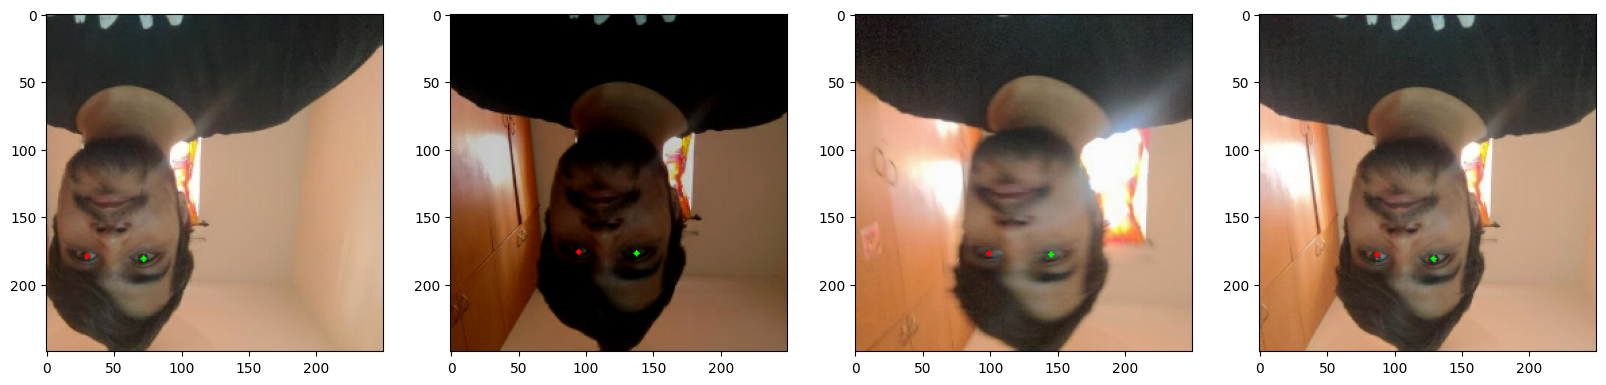

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

## 3. Build Model

### 3.1 Create Neural Network

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet50 

In [23]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet50(include_top=False, input_shape=(250,250,3), weights='imagenet'),  # Use ResNet50
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.2),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [24]:
model.layers[1].trainable = True


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 4)          

### 3.2 Setup Losses and Optimizer

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [27]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [28]:
X, y = train.as_numpy_iterator().next()

In [29]:
X.shape

(8, 250, 250, 3)

In [30]:
scores = model.predict(X)

1/1 [==============================] - 9s 9s/step


In [31]:
scores

array([[-0.23762524,  0.10987055, -0.28400934,  0.6765931 ],
       [-0.20521739,  0.09289873, -0.25238264,  0.6562574 ],
       [-0.25363153,  0.15706383, -0.22196044,  0.6202365 ],
       [-0.25542283,  0.1455198 , -0.24976043,  0.67163706],
       [-0.27199906,  0.14746854, -0.23301975,  0.6471419 ],
       [-0.24920312,  0.10794795, -0.27965057,  0.61355317],
       [-0.2380784 ,  0.11110151, -0.21526007,  0.58452755],
       [-0.2869169 ,  0.10146896, -0.22886194,  0.61387306]],
      dtype=float32)

### 3.4 Train the Model

In [32]:
# train for 100 epochs
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
315/315 [==============================] - 114s 319ms/step - loss: 1.4573 - val_loss: 0.0882
Epoch 2/20
315/315 [==============================] - 99s 305ms/step - loss: 0.0107 - val_loss: 0.0503
Epoch 3/20
315/315 [==============================] - 99s 305ms/step - loss: 0.0083 - val_loss: 0.0180
Epoch 4/20
315/315 [==============================] - 100s 308ms/step - loss: 0.0058 - val_loss: 0.0132
Epoch 5/20
315/315 [==============================] - 100s 308ms/step - loss: 0.0041 - val_loss: 0.0132
Epoch 6/20
315/315 [==============================] - 100s 307ms/step - loss: 0.0033 - val_loss: 0.0111
Epoch 7/20
315/315 [==============================] - 100s 307ms/step - loss: 0.0023 - val_loss: 0.0108
Epoch 8/20
315/315 [==============================] - 99s 306ms/step - loss: 0.0028 - val_loss: 0.0132
Epoch 9/20
315/315 [==============================] - 100s 307ms/step - loss: 0.0019 - val_loss: 0.0100
Epoch 10/20
315/315 [==============================] - 102s 313ms/s

## 4. Review Performance

### 4.1 View Loss Plots

In [33]:
hist.history

{'loss': [1.4573012590408325,
  0.010728818364441395,
  0.008337612263858318,
  0.005846536252647638,
  0.00405557407066226,
  0.0033108254428952932,
  0.0023286102805286646,
  0.0027919865678995848,
  0.0018969302764162421,
  0.0017290270188823342,
  0.001575416186824441,
  0.0015372863272204995,
  0.0015775510109961033,
  0.0015871678479015827,
  0.0013400091556832194,
  0.0014145050663501024,
  0.0029979185201227665,
  0.0019507165998220444,
  0.0017477050423622131,
  0.0012899331049993634],
 'val_loss': [0.08820769190788269,
  0.05029192939400673,
  0.01803450845181942,
  0.013169932179152966,
  0.013207539916038513,
  0.011138186790049076,
  0.01077800989151001,
  0.01322047971189022,
  0.010036113671958447,
  0.010776674374938011,
  0.010991325601935387,
  0.012617023661732674,
  0.008629612624645233,
  0.011362997815012932,
  0.009947923012077808,
  0.017531633377075195,
  0.01617220602929592,
  0.008570095524191856,
  0.009034484624862671,
  0.009730055928230286]}

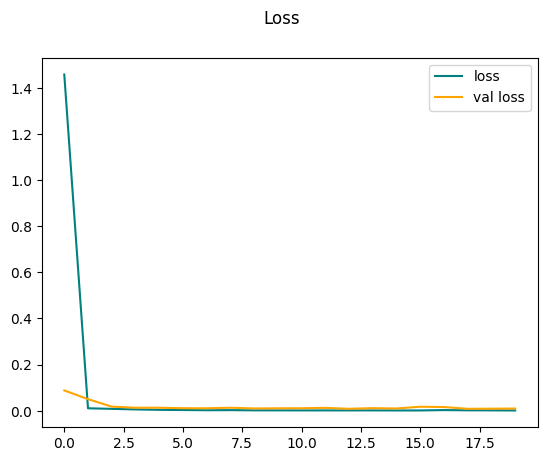

In [34]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2 Make Predictions on Test

In [35]:
test_data = test.as_numpy_iterator()

In [36]:
test_sample = test_data.next()

In [37]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


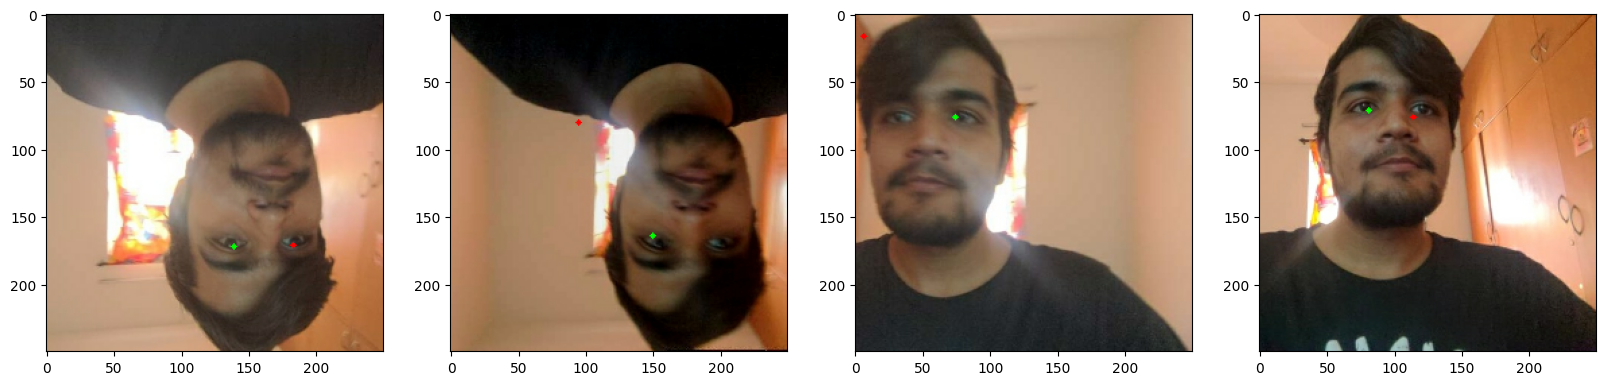

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### 4.3 Save the Model

In [39]:
from tensorflow.keras.models import load_model

In [40]:
model.save('eyetrackerresnet.h5')

In [41]:
model = load_model('eyetrackerresnet.h5')

In [42]:
model.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


array([[ 2.267661  ,  1.3826976 , -0.84931415, -0.12389646],
       [ 1.2177261 ,  1.6913438 , -0.11021695,  0.65773475],
       [ 0.9710917 ,  1.9915472 ,  2.2266333 ,  1.3080102 ],
       [ 0.2685703 ,  1.8923368 ,  0.24893408,  1.332786  ],
       [ 0.04768398,  0.04684029,  0.50439686,  0.31631935],
       [-0.01341683,  0.01880417,  0.5562959 ,  0.66208047],
       [ 0.11376096,  0.6971759 ,  0.28025705,  0.7064481 ],
       [ 0.2592334 ,  0.33935004,  0.39613008,  0.33036333]],
      dtype=float32)

## 5. Real Time Detection

1/1 [==============================] - 0s 30ms/step


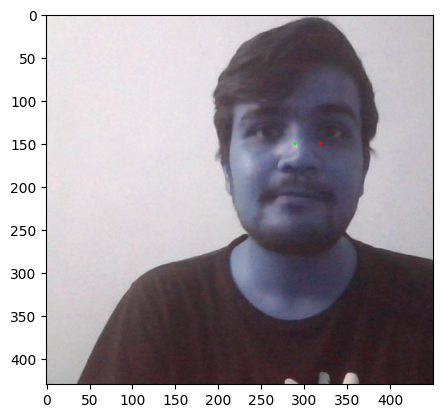

1/1 [==============================] - 0s 36ms/step


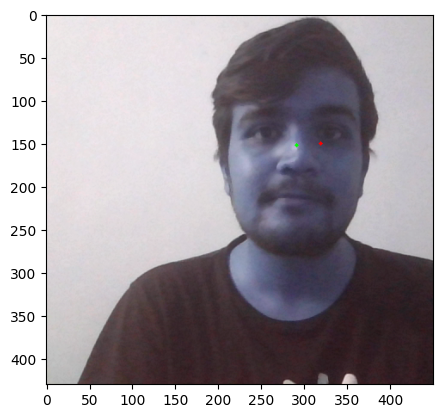

1/1 [==============================] - 0s 33ms/step


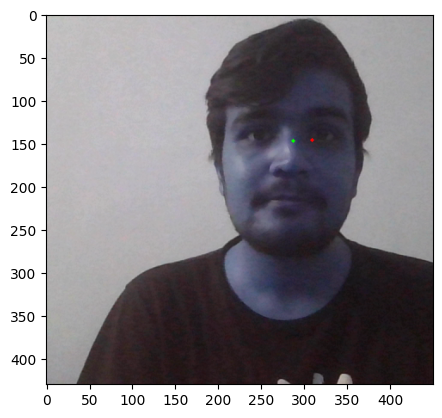

1/1 [==============================] - 0s 34ms/step


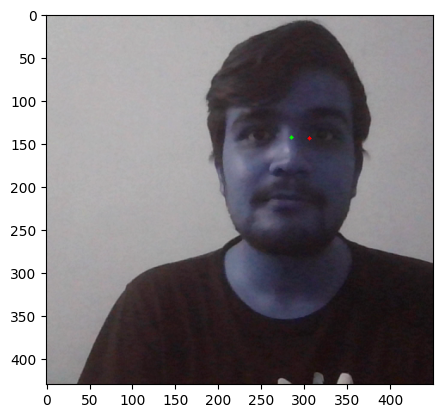

1/1 [==============================] - 0s 39ms/step


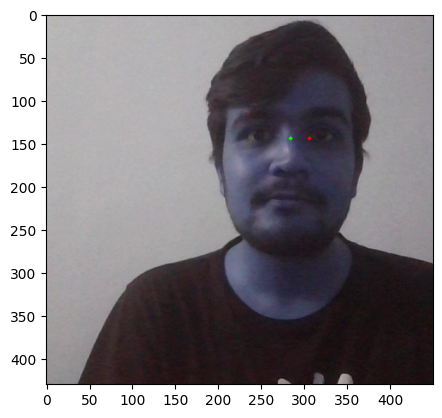

1/1 [==============================] - 0s 40ms/step


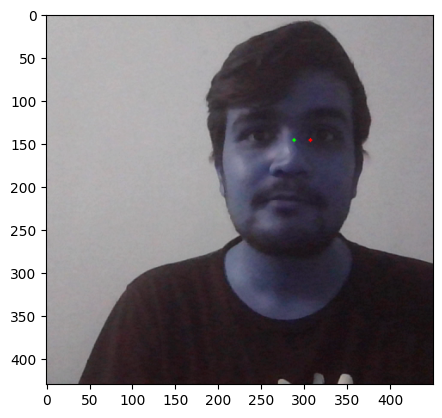

1/1 [==============================] - 0s 29ms/step


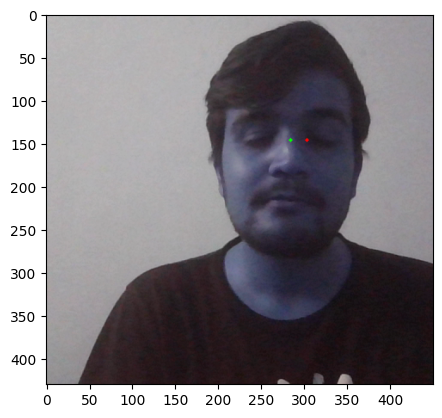

1/1 [==============================] - 0s 41ms/step


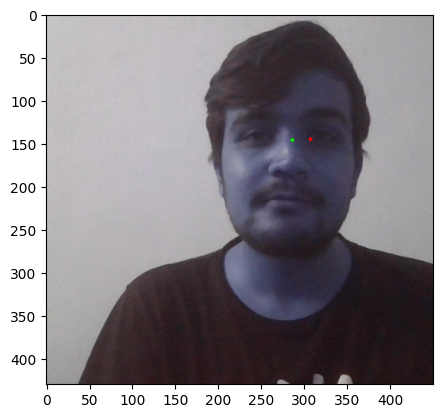

1/1 [==============================] - 0s 34ms/step


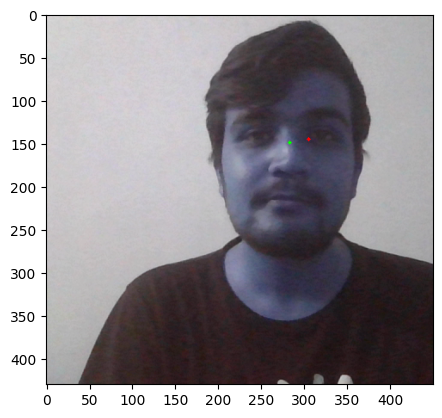

1/1 [==============================] - 0s 28ms/step


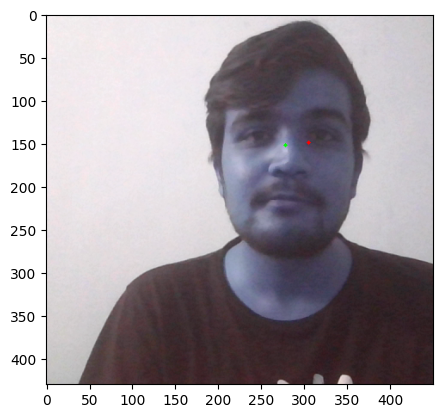

In [61]:
cap = cv2.VideoCapture(0)
counter = 0
max_counter = 10 # Set this to the number of frames you want to capture

while cap.isOpened() and counter < max_counter:
    ret, frame = cap.read()
    
    # Check if frame is not None
    if frame is not None:
        frame = frame[50:500,50:500,:]
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(rgb_img, (250,250))
    
        yhat = model.predict(np.expand_dims(resized/255,0))
        sample_coords = yhat[0,:4]
    
        cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
        plt.imshow(frame)
        plt.show()

        counter += 1
    else:
        print("Can't receive frame (stream end?). Exiting ...")
        break

cap.release()